# BNK48 - 6th Single Election Youtube Videos

In [1]:
import pandas as pd
import numpy as np
import json
import re
from datetime import datetime

from apiclient.discovery import build

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## Creating a Youtube service client
In order to call Youtube Data API to extract the required data, we need an **API Key**.<br/>
If you do not have one, follow the instruction on: https://developers.google.com/youtube/v3/getting-started

In [2]:
with open('./config.json') as f:
    config = json.load(f)
    
api_key = config['youtube']['api_key'] # or your api key

# Creating the client
client = build('youtube', 'v3', developerKey=api_key)

## Channel Information

In [3]:
channel_id = 'UClIsaGq7vBEW00ASqwQyzPw'

res = client.channels().list(
    part='snippet,contentDetails,statistics',
    id=channel_id
).execute()

In [4]:
def parse_date(datestring):
    return datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%S.%fZ")

title = res['items'][0]['snippet']['title']
description = res['items'][0]['snippet']['description']
publishedAt = parse_date(res['items'][0]['snippet']['publishedAt'])
imgurl = res['items'][0]['snippet']['thumbnails']['default']['url']

all_playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

viewCount = int(res['items'][0]['statistics']['viewCount'])
subscriberCount = int(res['items'][0]['statistics']['subscriberCount'])
videoCount = int(res['items'][0]['statistics']['videoCount'])

html = """
<table>
<tr><td></td><td style="text-align:left"><img src="{1}"/></td></tr>
<tr><td style="font-weight:bold">Channel</td><td style="text-align:left"><a href="https://www.youtube.com/channel/{0}">{2}</a></td></tr>
<tr><td style="font-weight:bold">Description</td><td style="text-align:left">{3}</td></tr>
<tr><td style="font-weight:bold">Published at</td><td style="text-align:left">{4}</td></tr>
<tr><td style="font-weight:bold">Subscribers</td><td style="text-align:left">{5:,}</td></tr>
<tr><td style="font-weight:bold">Total View</td><td style="text-align:left">{6:,}</td></tr>
<tr><td style="font-weight:bold">Videos</td><td style="text-align:left">{7:,}</td></tr>
</table>
""".format(channel_id, imgurl, title, description, datetime.strftime(publishedAt, '%b %d, %Y'), 
           subscriberCount, viewCount, videoCount)

display(HTML(html))

,
Channel,BNK48
Description,BNK48 Official YouTube Channel
Published at,"Mar 16, 2016"
Subscribers,"1,479,527"
Total View,"305,821,619"
Videos,343


### Channel Playlists

In [5]:
def get_youtube_list_items(resource, part, **kwargs):
    """ 
    Call list() method of the designated resource param (e.g. playlistItems(), videos(), etc.)
    Then iterate through the entire paginated result set using pageToken parameter.
    Extract and accumulate the content inside the 'items' key.
    """
    res = resource.list(part=part, **kwargs).execute()
    items = res['items']
    nextPageToken = res.get('nextPageToken','')
    while nextPageToken:
        res = resource.list(part=part, pageToken=nextPageToken, 
                            **kwargs).execute()
        items = items + res['items']
        nextPageToken = res.get('nextPageToken','')
    return items

In [6]:
items = get_youtube_list_items(client.playlists(), part='snippet,contentDetails',
                             channelId=channel_id, maxResults=50)
# res = client.playlists().list(part='snippet,contentDetails',
#                              channelId=channel_id, maxResults=50
#                              ).execute()

In [7]:
playlist_df = pd.DataFrame(list(map(lambda item: dict(
    id = item['id'],
    title = item['snippet']['title'],
    image = item['snippet']['thumbnails']['default']['url'],
    publishedAt = parse_date(item['snippet']['publishedAt']),
    itemCount = item['contentDetails']['itemCount']
), items)))

In [8]:
# table display
pd.set_option('display.max_colwidth', -1)

# CSS for table display
th_props = [
  ('padding','4px 4px'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
]

td_props = [
    ('padding','2px 4px'),
    ('font-size','smaller')
]
img_props = [
    ('width','auto'),
    ('height','75%')
]
styles = [
    dict(selector='th', props=th_props),
    dict(selector='td', props=td_props),
    dict(selector='img', props=img_props),
    dict(selector='tr:nth-child(even)', props=[('background','#f7f7f9')])
]

formatters = {'View': '{:,}','Image':'<img src="{}"/>',
                '% Liked': '{:.2f}%', '% Disliked': '{:.2f}%', 
                '% Commented': '{:.2f}%'}

In [9]:
data = playlist_df[['image','title','itemCount','publishedAt', 'id']]
data.columns = ['Image','Playlist','Video Count','Published Date','ID']
data.index = np.arange(1, data.shape[0]+1)

display(HTML(
    data.style
        .format(formatters)
        .set_table_styles(styles)
        .render()
))

,Image,Playlist,Video Count,Published Date,ID
1,,BNK48 6th Single Senbatsu General Election Appeal Comment,51,2018-11-13 03:17:13,PLPW9IgM1jwds4YyhRhtnoRDOGobY3SoU3
2,,Cherprang Vlog,5,2018-09-15 17:41:16,PLPW9IgM1jwdvXhtdR2vXYlfPnTdIV21oW
3,,KhunKai’s Kitchen,30,2018-09-03 04:49:01,PLPW9IgM1jwdth75t8dTbE8F3VpDNwC6Bj
4,,เพื่อนร่วมทาง The Journey,39,2018-01-11 16:47:09,PLPW9IgM1jwdt1go717kwU0cUJkIsYI2yf
5,,Music Video,7,2018-01-07 07:07:49,PLPW9IgM1jwduLMYMA6x3K6ExwDntxE-qP
6,,BNK48 We Wish You! A Merry Christmas –Fan Meet–,10,2018-01-07 07:05:03,PLPW9IgM1jwds1P4bMZRwJ4lnin-m9MXMG
7,,BNK48 Mini Live and Handshake,5,2017-11-21 10:33:13,PLPW9IgM1jwduNanV2hswU7WjPCgMg5LJB
8,,BNK48 Free Time,2,2017-09-15 13:30:16,PLPW9IgM1jwdvgxEycT7HsH9caHJ8phnQt
9,,BNK48 SHOW,52,2017-07-10 11:02:14,PLPW9IgM1jwduwDVmNQrQvMVR2y0Npa06E
10,,29 Seconds of 29 members,29,2017-04-30 18:15:04,PLPW9IgM1jwdt9NmUwhwcs8xBDC10fVqhL


### Playlist Items

In [11]:
playlist_id = 'PLPW9IgM1jwds4YyhRhtnoRDOGobY3SoU3'

# res = client.playlistItems().list(part='snippet',
#                                  playlistId=playlist_id,
#                                  maxResults=50).execute()

items = get_youtube_list_items(client.playlistItems(), part='snippet', playlistId=playlist_id)
print('Video count: {}'.format(len(items)))

Video count: 51


In [12]:
vdo_ids = list(map(lambda item: item['snippet']['resourceId']['videoId'], items))
vdo_ids[:5]

['PlBmrf9NvFA', 'akWfxC2jI5Q', 'qh3-_pJCXPw', 'r78Ss9ObGqk', 'hVLgSOgJQ9Y']

In [13]:
# timestamp
timestamp = datetime.now()
timestamp_text = datetime.strftime(timestamp, '%Y%m%d_%H%M%S')
timestamp

datetime.datetime(2018, 11, 19, 17, 41, 41, 91824)

In [14]:
BATCH_SIZE = 50

items = []
curr_idx = 0

# Get video info in batch
while curr_idx <= len(vdo_ids):
    ids = ','.join(vdo_ids[curr_idx:curr_idx+BATCH_SIZE])
    
    res = client.videos().list(
        part='snippet,contentDetails,statistics',
        id=ids
    ).execute()
    items = items + res['items']
    curr_idx = curr_idx + BATCH_SIZE

len(items)

51

In [15]:
videos = pd.DataFrame(list(map(lambda item: dict(
    id = item['id'],
    title = item['snippet'].get('title', np.nan),
    publishedDate = item['snippet'].get('publishedAt', np.nan),
    image = item['snippet']['thumbnails']['default']['url'],
    
    duration = item['contentDetails'].get('duration', np.nan),
    view = item['statistics'].get('viewCount', np.nan),
    like = item['statistics'].get('likeCount', np.nan),
    dislike = item['statistics'].get('dislikeCount', np.nan),
    comment = item['statistics'].get('commentCount', np.nan)
), items)))

# videos

In [16]:
videos.isnull().sum()

comment          0
dislike          0
duration         0
id               0
image            0
like             0
publishedDate    0
title            0
view             0
dtype: int64

In [17]:
name_pattern = re.compile('\((\w+)\)')
# extract member name from video title
def parse_name(title):
    m = name_pattern.search(title)
    return m.group(1)
  
def parse_duration(duration):
    """ Return seconds from the duration string in iso8601 format
        Simple conversion that does not cover the date parts of the ISO format
    """
    m = re.search(r'(\d+)H', duration)
    dh = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)M', duration)
    dm = int(m.group(1)) if m else 0
    
    m = re.search(r'(\d+)S', duration)
    ds = int(m.group(1)) if m else 0
    
    return dh*3600 + dm*60 + ds

videos['name'] = videos['title'].apply(parse_name)
videos['duration'] = videos['duration'].apply(parse_duration)
videos['view'] = videos['view'].astype(int)
videos['like'] = videos['like'].astype(int)
videos['dislike'] = videos['dislike'].astype(int)
videos['comment'] = videos['comment'].astype(int)
videos['publishedDate'] = videos['publishedDate'].apply(parse_date)

videos['like_pct'] = videos['like']/videos['view']*100
videos['dislike_pct'] = videos['dislike']/videos['view']*100
videos['comment_pct'] = videos['comment']/videos['view']*100

videos.index = videos['name']
videos = videos[['name','title','image','view','like','like_pct','dislike','dislike_pct',
                  'comment','comment_pct','duration','publishedDate','id']]
videos.head()

,name,title,image,view,like,like_pct,dislike,dislike_pct,comment,comment_pct,duration,publishedDate,id
name,,,,,,,,,,,,,
Cherprang,Cherprang,BNK48 Team BⅢ｜BNK48 Captain｜Cherprang Areekul (Cherprang),https://i.ytimg.com/vi/PlBmrf9NvFA/default.jpg,200171,11284,5.637180,208,0.103911,924,0.461605,71,2018-11-16 05:45:01,PlBmrf9NvFA
Tarwaan,Tarwaan,BNK48 Team BⅢ｜Isarapa Thawatpakdee (Tarwaan),https://i.ytimg.com/vi/akWfxC2jI5Q/default.jpg,102601,4828,4.705607,41,0.039961,385,0.375240,106,2018-11-16 05:45:00,akWfxC2jI5Q
Jennis,Jennis,BNK48 Team BⅢ｜BNK48 Team BⅢ Vice Captain｜Jennis Oprasert (Jennis),https://i.ytimg.com/vi/qh3-_pJCXPw/default.jpg,118209,6605,5.587561,104,0.087980,482,0.407752,80,2018-11-16 05:45:00,qh3-_pJCXPw
Pupe,Pupe,BNK48 Team BⅢ｜Jiradapa Intajak (Pupe),https://i.ytimg.com/vi/r78Ss9ObGqk/default.jpg,192861,10893,5.648109,114,0.059110,1060,0.549619,98,2018-11-16 05:45:00,r78Ss9ObGqk
Noey,Noey,BNK48 Team BⅢ｜Kanteera Wadcharathadsanakul (Noey),https://i.ytimg.com/vi/hVLgSOgJQ9Y/default.jpg,157532,7654,4.858695,146,0.092680,829,0.526242,140,2018-11-16 05:45:00,hVLgSOgJQ9Y


In [18]:
videos.to_csv('output/6th_single_election_videos_{}.csv'.format(timestamp_text), index=False, encoding='utf-8')

### Top 10 - Most Viewed

In [19]:
df = videos[['image','name','view','like_pct','dislike_pct','comment_pct','duration']]
df.columns = ['Image','Member','View','% Liked','% Disliked','% Commented','Duration']

# Top Views
data = df.sort_values('View', ascending=False)[:10]
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format(formatters)
        .set_table_styles(styles)
        .render()
))

,Image,Member,View,% Liked,% Disliked,% Commented,Duration
1,,Cherprang,"200,171",5.64%,0.10%,0.46%,71
2,,Pupe,"192,861",5.65%,0.06%,0.55%,98
3,,Mobile,"172,448",4.97%,0.09%,0.46%,127
4,,Noey,"157,532",4.86%,0.09%,0.53%,140
5,,Music,"151,997",5.28%,0.23%,0.78%,126
6,,Pun,"143,408",6.15%,0.07%,0.50%,85
7,,Jennis,"118,209",5.59%,0.09%,0.41%,80
8,,Orn,"113,724",5.03%,0.12%,0.47%,68
9,,Namneung,"106,879",6.77%,0.03%,0.98%,89
10,,Tarwaan,"102,601",4.71%,0.04%,0.38%,106


### Top 10 - % Liked

In [20]:
# Top Views
data = df.sort_values('% Liked', ascending=False)[:10]
data.index = np.arange(1, data.shape[0]+1)

# Render table in html
display(HTML(
    data.style
        .format(formatters)
        .set_table_styles(styles)
        .render()
))

,Image,Member,View,% Liked,% Disliked,% Commented,Duration
1,,Namneung,"106,879",6.77%,0.03%,0.98%,89
2,,Wee,"95,777",6.58%,0.10%,0.72%,107
3,,Kaew,"87,898",6.46%,0.05%,0.57%,120
4,,Phukkhom,"84,197",6.21%,0.08%,0.53%,79
5,,Pun,"143,408",6.15%,0.07%,0.50%,85
6,,Gygee,"55,735",6.07%,0.06%,0.68%,104
7,,Izurina,"53,131",6.01%,0.05%,0.54%,69
8,,Myyu,"42,216",5.84%,0.12%,0.41%,87
9,,Pupe,"192,861",5.65%,0.06%,0.55%,98
10,,Cherprang,"200,171",5.64%,0.10%,0.46%,71


### Distributions

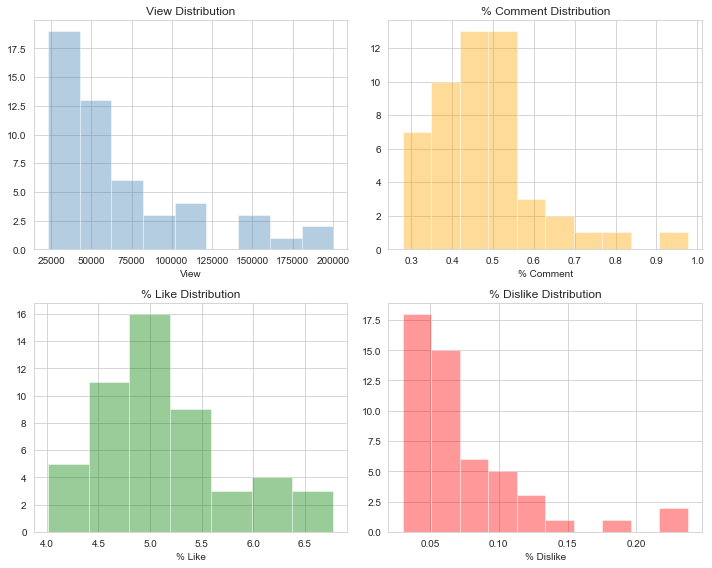

In [21]:
sns.set_style('whitegrid')

f, axes = plt.subplots(2,2, figsize=(10,8))
kws=dict(edgecolor='white', linewidth=1)

ax = sns.distplot(videos['view'], axlabel='View', 
                  kde=False, ax=axes[0,0], color='steelblue', hist_kws=kws)
ax.set_title('View Distribution')

ax = sns.distplot(videos['comment_pct'], axlabel='% Comment', 
                  kde=False, ax=axes[0,1], color='orange', hist_kws=kws)
ax.set_title('% Comment Distribution')

ax = sns.distplot(videos['like_pct'], axlabel='% Like', 
                  kde=False, ax=axes[1,0], color='green', hist_kws=kws)
ax.set_title('% Like Distribution')

ax = sns.distplot(videos['dislike_pct'], axlabel='% Dislike', 
                  kde=False, ax=axes[1,1], color='red', hist_kws=kws)
ax.set_title('% Dislike Distribution')

plt.tight_layout();


### How do viewers interact with the videos?

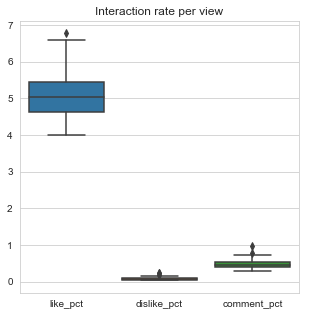

In [22]:
plt.figure(figsize=(5,5))
sns.boxplot(data=videos[['like_pct','dislike_pct','comment_pct']])
plt.title('Interaction rate per view');

### Bar plots

In [ ]:
f, axes = plt.subplots(3,1, figsize=(18,12), dpi=100)
df.index = df['Member']
df.sort_values('View', ascending=False)['View'].plot.bar(rot=65, title='View', ax=axes[0], color='steelblue')
(df.sort_values('% Liked', ascending=False)['% Liked']).plot.bar(rot=65, title='Like per View Percentage', ax=axes[1], color='green')
(df.sort_values('% Commented', ascending=False)['% Commented']).plot.bar(rot=65, title='Comment per View Percentage', ax=axes[2], color='orange')
plt.tight_layout();

In [ ]:
# Loading member info for further analysis
member_info = pd.read_csv('datasets/bnk48member_info.csv')
member_info = member_info.query('active == 1')

member_info['name'] = member_info['name'].replace({'June':'Juné', 'Rina': 'Izurina'})

member_info.index = member_info['name']
member_info.head()

In [ ]:
from pandas.tools.plotting import parallel_coordinates

data = videos[['view','like_pct','comment_pct','dislike_pct']]
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
data = data.join(member_info['generation'])

parallel_coordinates(data, 'generation', colormap='Set3');

### Scatter plots

In [ ]:
fb = pd.read_csv('datasets/fb_2018-11-19.csv', names=['name','datetime','fans'], header=0, parse_dates=['datetime'])

fb_name_mapper = member_info.set_index('fb_name')['name']

fb = fb.assign(name = fb['name'].map(fb_name_mapper)).dropna()
fb_fans = fb.groupby('name')['fans'].max()

In [ ]:
plt.figure(figsize=(6,4),dpi=100)
temp = videos.join(fb_fans, on='name')
temp['like_pct'] = temp['like_pct']
temp['comment_pct'] = temp['comment_pct']

sns.regplot(x='fans', y='view', data=temp)
plt.xlabel('Facebook Fans');
plt.title('Facebook Fans vs Youtube View');
# plt.ylabel('')

In [ ]:
plt.figure(figsize=(6,4),dpi=100)
sns.regplot(x='fans', y='like_pct', data=temp)
plt.xlabel('Facebook Fans');
plt.title('Facebook Fans vs % Like');

In [ ]:
plt.figure(figsize=(6,4),dpi=100)
sns.regplot(x='fans', y='comment_pct', data=temp)
plt.xlabel('Facebook Fans');
plt.title('Facebook Fans vs % Comment');

## Correlation

In [ ]:
cols = ['view','like','dislike','comment','like_pct','dislike_pct', 'comment_pct']
corr = videos[cols].corr()

plt.figure(figsize=(7.5,5))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask=mask, cmap='RdYlGn', annot=True, fmt='.2f', vmin=-1.0, vmax=1.0)

ax.set_title('Video Statistics Correlations');